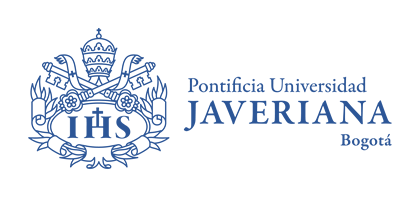

# **Proyecto Imagenes - Procesamiento de Imágenes**

### **Realizado por:**

- Carlos Másmela
- Yudy Pedraza

### **Resumen:**

El siguiente Notebook tiene como propósito mostrar la solución al problema de clasificación de tumores cerebrales, mediante **Transfer Learning y Fine-Tuning**.

# **Librerías**

In [ ]:
!pip install plot-keras-history --quiet
!pip install split-folders --quiet

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import warnings
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import random

import splitfolders

from collections import defaultdict

from plot_keras_history import plot_history

# **Lectura de data**

In [ ]:
!git clone https://github.com/candemas97/tumores_cerebrales

Cloning into 'tumores_cerebrales'...
remote: Enumerating objects: 6756, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 6756 (delta 3), reused 16 (delta 2), pack-reused 6739
Receiving objects: 100% (6756/6756), 202.57 MiB | 24.85 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (7028/7028), done.


Se toman las rutas

In [ ]:
train_dir = r'./tumores_cerebrales/Imágenes Cerebrales/Training'
test_dir = './tumores_cerebrales/Imágenes Cerebrales/Testing'

Se crea una nueva carpeta con las imágenes separadas

In [ ]:
splitfolders.ratio(train_dir, output="output", ratio=(0.8,0.2))
warnings.filterwarnings("ignore")

Copying files: 5712 files [00:02, 2349.21 files/s]


Se copia la nueva ruta

In [ ]:
train_dir = './output/train'
val_dir = './output/val'

Se procede a almacener la ruta de la categoría y de la imagen. Tanto para train como para test.

In [ ]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [ ]:
val_paths = []
val_labels = []

for label in os.listdir(val_dir):
    for image in os.listdir(val_dir+"//" +label):
        val_paths.append(val_dir + '//'+label+ '//'+image)
        val_labels.append(label)

val_paths, val_labels = shuffle(val_paths, val_labels)

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+ '//' + label):
        test_paths.append(test_dir +'//'+label + '//'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# **Modelamiento**

Debido a que todo el preprocesamiento y análisis descriptivo fue realizado en etapas anteriores se procede a realizar los modelos.

In [ ]:
def plot_prediction_results(model, num_pixels = None, pre_process_fn = None, resize = None):
    # Load the CIFAR-10 dataset
    (_, _), (test_images, test_labels) = datasets.cifar10.load_data()

    # Get shuffled indices for unique image selection
    num_plots = 10
    indices = np.arange(len(test_images))
    np.random.shuffle(indices)

    sampled_images = test_images[indices[:num_plots]]
    sampled_labels = test_labels[indices[:num_plots]]

    # If you want to apply transformations, make a copy of the sampled images
    # This copy will be used for model predictions
    transformed_images = sampled_images.copy()

    if num_pixels:
        original_shape = test_images.shape
        transformed_images = transformed_images.reshape((num_plots,) + (num_pixels,))

    if resize:
        transformed_images = tf.image.resize(transformed_images, resize)

    # Normalize the test images
    if pre_process_fn:
        print('Using Pre-Trained Model Process')
        pred_images = pre_process_fn(transformed_images)
    else:
        pred_images = transformed_images.astype('float32') / 255

    # Get predictions from the model on the random sample
    predictions = model.predict(pred_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Map class indices to class names
    class_names = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }

    # Plot random image, predicted label, true label, and prediction probability
    fig, axs = plt.subplots(2, 5, figsize=(12, 8))
    fig.suptitle('Prediction Results')

    for i in range(num_plots):
        row = i // 5
        col = i % 5
        ax = axs[row, col]

        # Select a unique test sample
        image = sampled_images[i]
        true_label = sampled_labels[i][0]
        predicted_label = predicted_labels[i]
        prediction_probability = predictions[i][predicted_label]

        # Set title color based on prediction correctness
        title_color = 'green' if predicted_label == true_label else 'red'

        # Plot the image, labels, and probability
        ax.imshow(image)
        ax.set_title(f'Predicted: {class_names[predicted_label]}\nTrue: {class_names[true_label]}\nProbability: {prediction_probability:.4f}', color=title_color)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## *Transfer Learning*

In [ ]:
ancho, alto = 512, 512
vector_canal = ancho * alto
num_pixels = vector_canal * 512

Se carga modelo preentrenado

In [ ]:
### Cargue el Modelo
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(244, 244, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
###


pre_process_fn = tf.keras.applications.resnet50.preprocess_input

94765736/94765736 [==============================] - 1s 0us/step


Se observa arquitectura del modelo

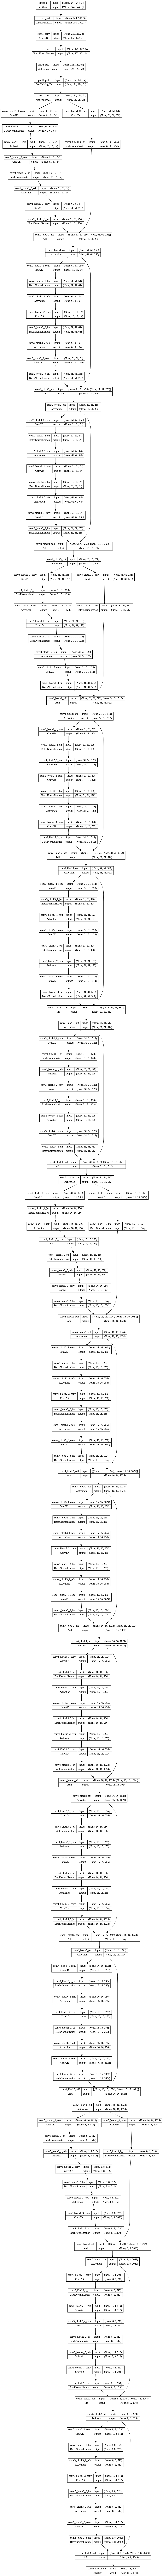

In [ ]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

Se observa cantidad de parámetros del modelo

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 244, 244, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 250, 250, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 122, 122, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 122, 122, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
x = base_model.output # Corresponde a los features que extrae el modelo

### Continúe la construcción del Modelo

x = tf.keras.layers.GlobalAveragePooling2D()(x) # GlobalAveragePooling2D
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(4, activation='softmax')(x) # Añada la capa de salida (predicción de las clases)

###

In [ ]:
fine_tune_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
fine_tune_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()],
              optimizer =tf.keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
fine_tune_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 244, 244, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 250, 250, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 122, 122, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 122, 122, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0.1,
                                    zoom_range = 0.2,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)
generator_test = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=False,
                                    vertical_flip=False)

train = generator_train.flow_from_directory(train_dir, target_size=(244, 244),
                                              batch_size=32, class_mode= "categorical", color_mode='rgb')
val = generator_test.flow_from_directory(val_dir, target_size=(244, 244),
                                              batch_size=32, class_mode= "categorical", color_mode='rgb')
test = generator_test.flow_from_directory(test_dir, target_size=(244, 244),
                                              batch_size=32, class_mode= "categorical", color_mode='rgb')

Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history_fine_tune_model = fine_tune_model.fit(train, steps_per_epoch=len(train_paths)//32, epochs=20, validation_data=val, validation_steps= len(val_paths)//32, callbacks=[early_stopping])

Epoch 1/20
142/142 [==============================] - 79s 556ms/step - loss: 1.0612 - categorical_accuracy: 0.5192 - val_loss: 0.9195 - val_categorical_accuracy: 0.6473
Epoch 2/20
142/142 [==============================] - 77s 544ms/step - loss: 1.0727 - categorical_accuracy: 0.5075 - val_loss: 0.9233 - val_categorical_accuracy: 0.6500
Epoch 3/20
142/142 [==============================] - 79s 555ms/step - loss: 1.0879 - categorical_accuracy: 0.4857 - val_loss: 1.0419 - val_categorical_accuracy: 0.5625
Epoch 4/20
142/142 [==============================] - 79s 558ms/step - loss: 1.1007 - categorical_accuracy: 0.4810 - val_loss: 1.0525 - val_categorical_accuracy: 0.5973
Epoch 5/20
142/142 [==============================] - 84s 590ms/step - loss: 1.0946 - categorical_accuracy: 0.4824 - val_loss: 1.0250 - val_categorical_accuracy: 0.4929
Epoch 6/20
142/142 [==============================] - 81s 569ms/step - loss: 1.0894 - categorical_accuracy: 0.4932 - val_loss: 0.9518 - val_categorical_acc

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Categorical accuracy'}, xlabel='Epochs', ylabel='Categorical accuracy'>],
       dtype=object))

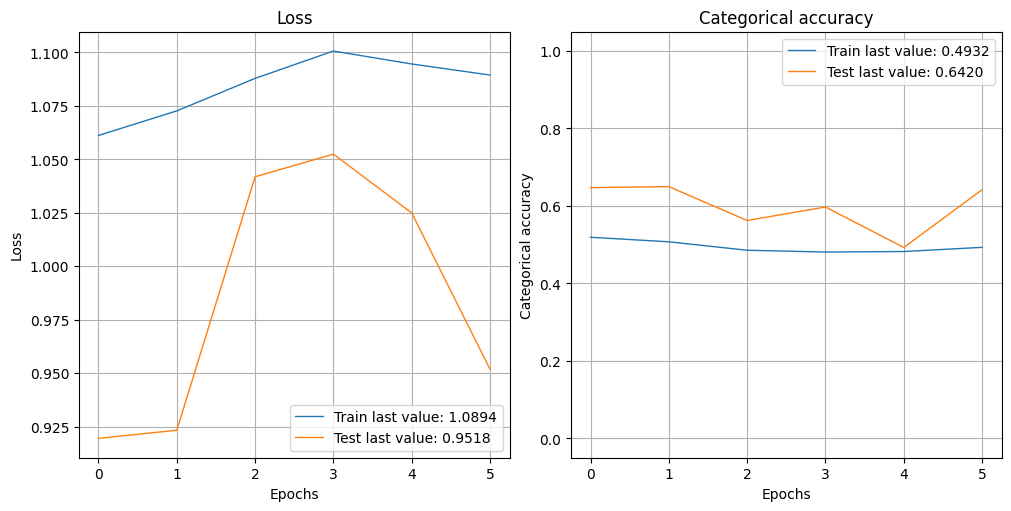

In [ ]:
plot_history(history_fine_tune_model)

In [ ]:
fine_tune_model.evaluate(test)

41/41 [==============================] - 5s 127ms/step - loss: 1.0074 - categorical_accuracy: 0.6034


[1.0074177980422974, 0.6033562421798706]

## *Fine Tuning*

In [ ]:
for layer in base_model.layers[143:]:
    layer.trainable = True


### Compile el Modelo
fine_tune_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()],
              optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001))
###

history_fine_tune_model_f = fine_tune_model.fit(train, steps_per_epoch=len(train_paths)//32, epochs=20, validation_data=(val), validation_steps= len(val_paths)//32, callbacks=[early_stopping])


Epoch 1/20
142/142 [==============================] - 93s 576ms/step - loss: 1.7290 - categorical_accuracy: 0.5370 - val_loss: 1.2365 - val_categorical_accuracy: 0.4045
Epoch 2/20
142/142 [==============================] - 83s 587ms/step - loss: 0.8319 - categorical_accuracy: 0.6299 - val_loss: 0.6829 - val_categorical_accuracy: 0.7563
Epoch 3/20
142/142 [==============================] - 84s 589ms/step - loss: 0.7202 - categorical_accuracy: 0.7063 - val_loss: 0.6474 - val_categorical_accuracy: 0.7625
Epoch 4/20
142/142 [==============================] - 87s 613ms/step - loss: 0.6901 - categorical_accuracy: 0.7205 - val_loss: 1.0163 - val_categorical_accuracy: 0.5884
Epoch 5/20
142/142 [==============================] - 87s 615ms/step - loss: 0.6122 - categorical_accuracy: 0.7537 - val_loss: 0.6082 - val_categorical_accuracy: 0.7661
Epoch 6/20
142/142 [==============================] - 86s 606ms/step - loss: 0.5777 - categorical_accuracy: 0.7659 - val_loss: 0.6449 - val_categorical_acc

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Categorical accuracy'}, xlabel='Epochs', ylabel='Categorical accuracy'>],
       dtype=object))

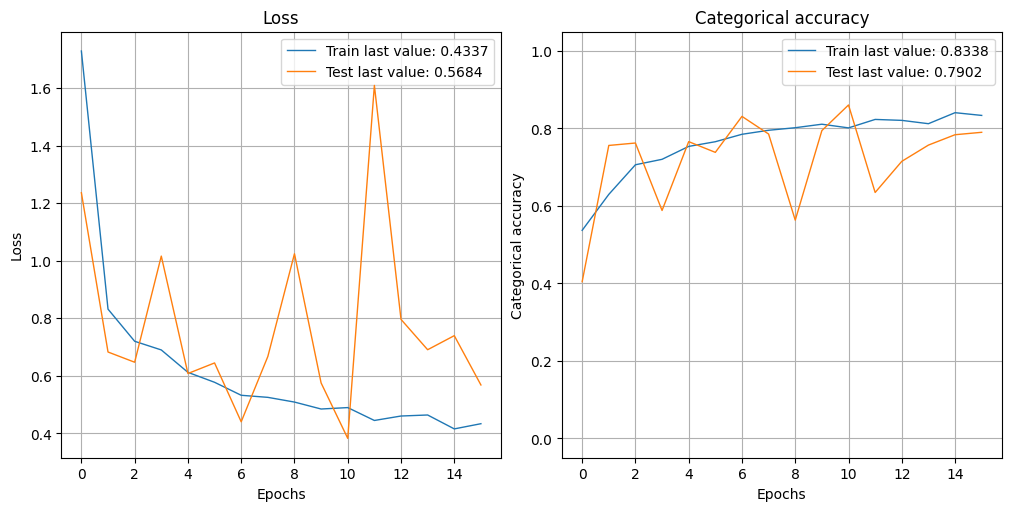

In [ ]:
plot_history(history_fine_tune_model_f)

In [ ]:
fine_tune_model.evaluate(test)

41/41 [==============================] - 6s 133ms/step - loss: 0.4754 - categorical_accuracy: 0.8063


[0.4753832221031189, 0.8062547445297241]